In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import re
import seaborn as sns
sns.set_style("whitegrid")

%matplotlib inline

# Modeling UAAP Basketball Using Bayesian Networks



I was interested in making a simple example to use Bayesian networks. I came across this [blog post by Daniel Weitzenfeld](http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/), which he based on this [paper](http://www.statistica.it/gianluca/Research/BaioBlangiardo.pdf). They tackled (pun not intended) football data, and thought to use their methods using basketball, the more popular sport in the Philippines.

The University Athletic Association of the Philippines (UAAP) is a college sports league comprising of 8 universities. Every year, the 8 universities compete in 15 sports categories. UAAP basketball games are especially popular in Manila.

We'll use points data from the first half of UAAP Season 79's men's basketball tournament to accomplish 2 things: *(1) uncover the latent offensive and defensive strengths of each team*, and *(2) simulate game outcomes for the second half of the season* (just before playoffs).

This notebook will have 3 main parts:
* Web scraping and data wrangling 
    * We'll scrape the data from Wikipedia and shape it into a format ready for modeling.
* Modeling 
    * We'll model a Bayesian Network and "estimate" the model's parameters using Markov Chain Monte Carlo.
* Simulation
    * We'll simulate the rest of the season's games.

# Web Scraping to Grab Basketball Data


We need to get historical data on final scores between every pair of teams. Conveniently, it's available on Wikipedia. So we'll use `beautifulsoup` to scrape the table that we need.

We're only getting the data for Season 79 since UAAP teams signifcantly change the players on their rosters every year.

In [2]:
# function that takes in a url and returns the table from the season
def get_uaap_basketball(url):
    try:
        html = requests.get(url).text
        soup = BeautifulSoup(html, 'html.parser')
        content =  soup.find("span", attrs = {"class":"toctext"}, text = "Men's tournament")
        content = content.find_next("span", attrs = {"id":["Scores", "Results"]})
        content = content.find_next("table", attrs = {"class":"wikitable"})
    except:
        print("Error in getting table from {}".format(url))
    return content

In [3]:
# get the table for season 79 (the current season)
url = "https://en.wikipedia.org/wiki/UAAP_Season_79_basketball_tournaments"
season_table = get_uaap_basketball(url)

We have the table, but it's still in HTML. Let's convert it to a pandas dataframe.

In [4]:
# convert the table in HTML to a pandas dataframe
season_table = pd.read_html(str(season_table), flavor = "bs4", header = 0, index_col = 0)[0]
season_table.index = season_table.columns
season_table.replace(to_replace = "–", value = np.nan, inplace = True)
season_table

,AdU,ADMU,DLSU,FEU,NU,UE,UP,UST
AdU,NaN,62–61,75–91,65–75,64–51,57–64,104–85,79–52
ADMU,73–67,NaN,81–97,76–71,60–70,84–69,79–64,73–69
DLSU,86–79,71–83,NaN,83–78,75–66,84–78,89–71,100–62
FEU,59–61,59–74,67–73,NaN,78–75,67–59,51–49,79–72
NU,53–77,50–65,88–113,56–57,NaN,72–66,80–69,75–68
UE,71–79,61–75,66–95,61–64,52–64,NaN,71–75,87–88
UP,70–66,56–52,72–78,60–63,71–66,67–80,NaN,77–83
UST,61–76,64–74,56–99,48–59,73–69,61–71,69–75,NaN


In [5]:
# we'll use the scraped data as of oct 5 2016 (when season is halfway)
season_table = pd.read_csv("uaap_79_as_of_oct_5_2016.csv", encoding = "utf-8", index_col = 0)
season_table

,AdU,ADMU,DLSU,FEU,NU,UE,UP,UST
AdU,NaN,62–61,75–91,65–75,64–51,57–64,104–85,79–52
ADMU,NaN,NaN,81–97,76–71,60–70,84–69,79–64,73–69
DLSU,NaN,NaN,NaN,83–78,75–66,84–78,89–71,100–62
FEU,NaN,NaN,NaN,NaN,78–75,67–59,51–49,79–72
NU,NaN,NaN,NaN,NaN,NaN,72–66,80–69,75–68
UE,NaN,NaN,NaN,NaN,NaN,NaN,71–75,87–88
UP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77–83
UST,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Wrangling

Great. We have a table in pandas. But we need it in a format where every row is a match between two teams.

In [6]:
df = season_table.copy()
rows = []
for i in df.index:
    for c in df.columns:
        score = df.loc[i, c]
        if pd.isnull(score):
            continue
        # remove all asterisks after string splitting on – (en dash)
        score = [int(re.search(pattern = r"([0-9]*)\**", string = row).group(1)) for row in score.split("–")]
        rows.append([i, c, score[0], score[1]])
df = pd.DataFrame(rows, columns = ['home', 'away', 'home_score', 'away_score'])
df.head()

,home,away,home_score,away_score
0,AdU,ADMU,62,61
1,AdU,DLSU,75,91
2,AdU,FEU,65,75
3,AdU,NU,64,51
4,AdU,UE,57,64


We also have to assign indices to every team. This will be helpful in the model later.

In [7]:
teams = np.unique(np.concatenate([df.away.unique(), df.home.unique()]))
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index
teams

,team,i
0,ADMU,0
1,AdU,1
2,DLSU,2
3,FEU,3
4,NU,4
5,UE,5
6,UP,6
7,UST,7


Now we have the data in the format we need. Next part's defining the Bayesian network.

In [8]:
df = pd.merge(df, teams, left_on='home', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)
df.head()

,home,away,home_score,away_score,i_home,i_away
0,AdU,ADMU,62,61,1,0
1,AdU,DLSU,75,91,1,2
2,AdU,FEU,65,75,1,3
3,AdU,NU,64,51,1,4
4,AdU,UE,57,64,1,5


# Bayesian Network Model

The data we have is points scored for each game $g$: $(y_{g1}, y_{g2})$. The total points for the first team (home team) is $y_{g1}$, and the total points for the second team (away team) is $y_{g2}$. Just from using points data, we can do the following using a Bayesian Network:

1. *Uncover latent offensive and defensive strengths for each team.*
2. *Simulate the points scored of any two teams if they played against each other.*

## Poisson

Now let's set up the variables that make up this network. Remember that the Poisson distribution's good for modeling count data. So we're modelling the $y_{gj}$ as Poisson each with rate $\theta_{gj}$:
$$y_{gj} \sim Poisson(\theta_{gj})$$

The rate $\theta_{gj}$ can be interpreted as the average number of points scored by team $j$ if it's playing multiple games against the other team it played with in game $g$. For example, let's say in game 3 we have FEU go against NU. Then, the theta of FEU, $\theta_{31}$, is the expected number of points it will score against NU if they played with each other again with the same players.

## Log-linear model of theta

The points scored by a certain team, say FEU, is very dependent on which team it faces. We expect FEU to score lower points on average if it's going against tougher teams.

To make sure this is captured by our model, we introduce the components that make up each $\theta_{gj}$.

$$\theta_{g1} = exp(intercept + home + offense_{g1} - defense_{g2})$$
$$\theta_{g2} = exp(intercept + offense_{g2} - defense_{g1})$$

We're using the exponential of the latent parameters since the theta parameters should be positive values (average number of points scored can't be negative!).

Equivalently, we can have this log-linear formulation:

$$log(\theta_{g1}) = intercept + home + offense_{g1} - defense_{g2}$$
$$log(\theta_{g2}) = intercept + offense_{g2} - defense_{g1}$$

This model says that a team's propensity to score points (theta) gets **pulled up** by the team's offense, and gets **pulled down** by the opposing team's defense. Home court advantage (if it exists) also serves to **pull up** points. 

The intercept parameter serves as a baseline number of points in *any* basketball game. For example, no matter how bad or how good the teams are, you don't expect a team playing for around 48 minutes to end up with only 30 points. Like home court advantage, intercept is independent of the teams.

<img src = "images/bayesian network light.png", height = 350, width = 350>

## Putting things in perspective

From our the points data $(y_{g1}, y_{g2})$ that we can observe, we can figure out the latent parameters (no home court advantage in the UAAP setting): 
* $intercept$
* $offense_{g1}$, $offense_{g2}$
* $defense_{g1}$, $defense_{g2}$

## Defining priors

Before we can estimate the latent parameters, we need to specify prior distributions for each since we're in the Bayesian setting. I've copied Daniel Weitzenfeld and defined uninformative priors.

* $intercept \sim Normal(0, 10000)$
* $offense_t \sim Normal(\mu_{off_t}, 1/{\tau_{off_t}})$
* $defense_t \sim Normal(\mu_{def_t}, 1/{\tau_{def_t}})$

where

* $\mu_{off_t} \sim Normal(0, 10000)$
* $\mu_{def_t} \sim Normal(0, 10000)$
* $\tau_{off_t} \sim Gamma(0.1, 0.1)$ 
* $\tau_{def_t} \sim Gamma(0.1, 0.1)$
* $\sum\limits_{t = 1}^N {offense_t} = 0$
* $\sum\limits_{t = 1}^N {defense_t} = 0$

The last two sum-to-zero constraints ensure that the parameters are *identifiable*.

We'll use the magic of the Metropolis-Hastings algorithm to estimate the variables we've defined. 

# Setting Up the Model

Before running the algorithm, we'll define some necessary constants.

In [9]:
# observed data
observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values

# constants 
home_team = df.i_home.values
away_team = df.i_away.values
num_teams = len(teams)
num_games = df.shape[0]

Let's also define good starting values for the priors of $offense_t$ and $defense_t$. This helps the algorithm "sketch out" the posteriors faster. 

We'll use the log means of the home scores and away scores for each team.

In [10]:
g = df.groupby('i_away')
att_starting_points = np.log(g.away_score.mean())
g = df.groupby('i_home')
def_starting_points = np.log(g.home_score.mean())
starting_points = pd.DataFrame({"offense": att_starting_points, "defense": def_starting_points})
starting_points.fillna(starting_points.mean(), inplace = True)
starting_points

,defense,offense
0,4.324133,4.110874
1,4.280627,4.263606
2,4.456670,4.543295
3,4.230477,4.313034
4,4.326338,4.182050
5,4.369448,4.207673
6,4.343805,4.231688
7,4.333071,4.256625


Now it's time to dive into the heart of probabilistic programming - defining how the random variables relate to each other.

In [11]:
# builds the model from the "bottom up" (starting from the hyperpriors)

# no home court advantage in UAAP basketball
home = 0

# hyperpriors
tau_att = pm.Gamma('tau_att', 0.1, 0.1, value=10)
tau_def = pm.Gamma('tau_def', 0.1, 0.1, value=10)
intercept = pm.Normal('intercept', 0, 0.0001, value=0)

# team-specific parameters
atts_star = pm.Normal("atts_star", 
                        mu = 0, 
                        tau = tau_att, 
                        size = num_teams, 
                        value = starting_points.offense.values)
defs_star = pm.Normal("defs_star", 
                        mu = 0, 
                        tau = tau_def, 
                        size = num_teams, 
                        value = starting_points.defense.values) 


# trick to code the sum to zero contraint
@pm.deterministic
def atts(atts_star=atts_star):
    atts = atts_star.copy()
    atts = atts - np.mean(atts_star) 
    return atts
@pm.deterministic
def defs(defs_star=defs_star):
    defs = defs_star.copy()
    defs = defs - np.mean(defs_star)
    return defs

@pm.deterministic
def home_theta(home_team=home_team, 
               away_team=away_team, 
               home=home, 
               atts=atts, 
               defs=defs, 
               intercept=intercept):
    
    return np.exp(intercept + 
                  home + 
                  atts[home_team] - 
                  defs[away_team])
@pm.deterministic
def away_theta(home_team=home_team, 
               away_team=away_team, 
               home=home, 
               atts=atts, 
               defs=defs, 
               intercept=intercept): 
    
    return np.exp(intercept + 
                  atts[away_team] - 
                  defs[home_team])   


home_goals = pm.Poisson('home_goals', 
                          mu=home_theta, 
                          value=observed_home_goals, 
                          observed=True)
away_goals = pm.Poisson('away_goals', 
                          mu=away_theta, 
                          value=observed_away_goals, 
                          observed=True)

# Sampling from the Posteriors

With the model set up, we can now sample from posteriors of all of the variables.

In [12]:
# put all the variables inside the MCMC to get ready to "crank" the algorithm
mcmc = pm.MCMC([home, intercept, tau_att, tau_def, 
                  home_theta, away_theta, 
                  atts_star, defs_star, atts, defs, 
                  home_goals, away_goals])

map_ = pm.MAP(mcmc)
map_.fit()
iters = 500000
mcmc.sample(iters, burn = iters/3, thin = 20)

 [-----------------100%-----------------] 500000 of 500000 complete in 134.3 sec

# Visualizing the offense and defense parameters

Now we'll answer our first goal: *uncovering the latent offensive and defensive strengths of each team*.

When we perform Bayesian inference, we don't get a point estimate, we get an *entire distribution*. In our case, we have distributions for the offensive and defensive strengths of each team.

In order to make it easer to understand and visualize, we're going to get the medians and the standard deviations of those distributions we got.

In [13]:
df_summary = pd.DataFrame({"median_att": atts.stats()["quantiles"][50],
                       "std_att": atts.stats()["standard deviation"],
                       "median_def": defs.stats()["quantiles"][50],
                       "std_def": defs.stats()["standard deviation"]},
                      index=teams.team.values)

/Users/joshuacortez/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


We can now visualize what's going on with our teams. Clearly, DLSU is far ahead of the curve because of its offense. The offense makes up for its average defense. It is no surprise that they haven't lost a game in the first half of the season.

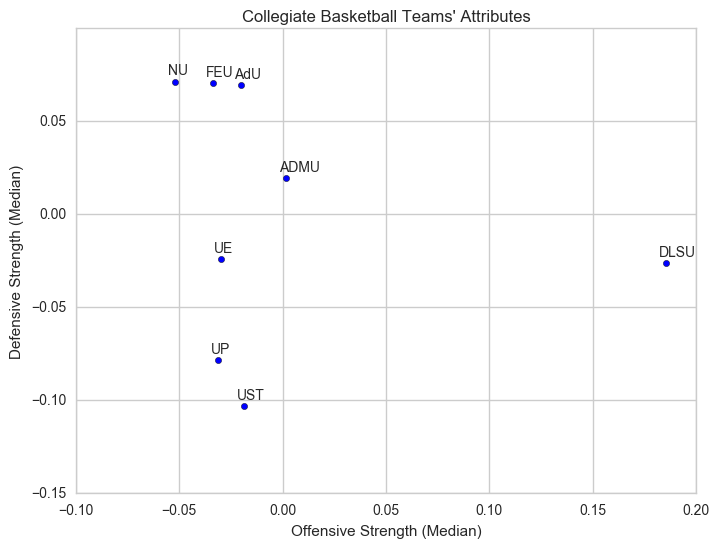

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
for label, x, y in zip(df_summary.index.values, df_summary.median_att.values, df_summary.median_def.values):
    ax.scatter(x,y)
    ax.annotate(label, xy=(x,y), xytext = (-5,5), textcoords = 'offset points')
ax.set_xlabel("Offensive Strength (Median)")
ax.set_ylabel("Defensive Strength (Median)")
plt.title("Collegiate Basketball Teams' Attributes")
plt.show()

This time, let's compare just the offensive strengths. I've added error bars to show a 95% credible interval (the Bayesian version of a confidence interval).

All teams aside from DLSU aren't significantly different from each other.

/Users/joshuacortez/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


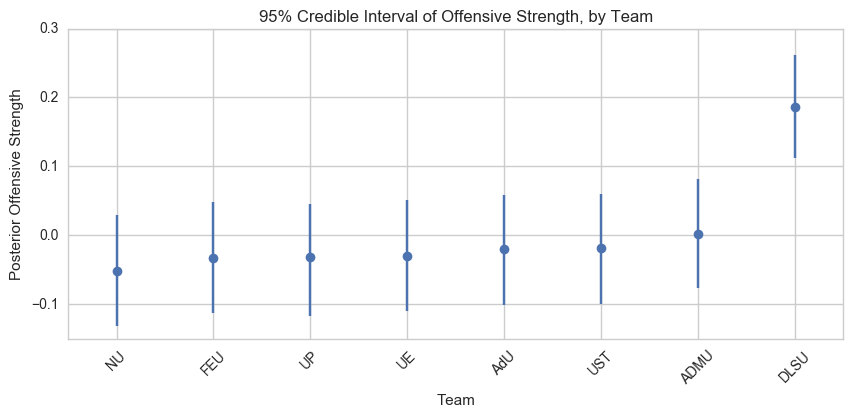

In [15]:
df_hpd = pd.DataFrame(atts.stats()['95% HPD interval'].transpose(), 
                      columns=['hpd_low', 'hpd_high'], 
                      index=teams.team.values)
df_median = pd.DataFrame(atts.stats()['quantiles'][50], 
                         columns=['hpd_median'], 
                         index=teams.team.values)

df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + 0.5
fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median, 
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
             fmt='o')
axs.set_title('95% Credible Interval of Offensive Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Offensive Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

Now let's graph the 95% credible intervals of the defensive strengths.

There seem to be three tiers of defensive strength:
- Top (Adu, NU, FEU)
- Middle (DLSU, UE, ADMU)
- Bottom (UST, UP)

/Users/joshuacortez/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:224: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


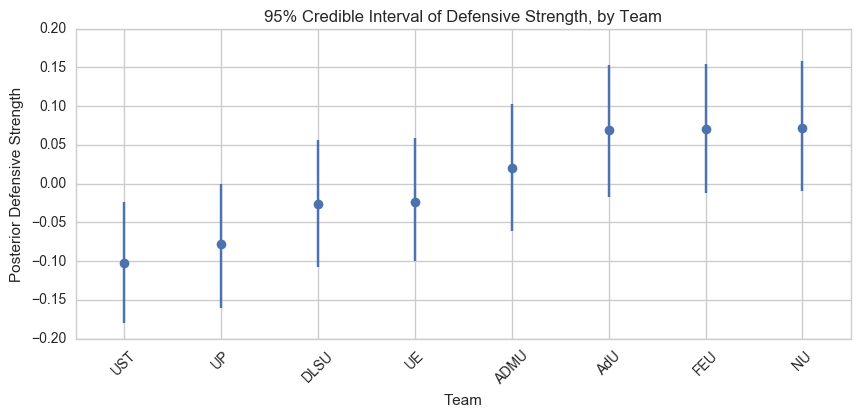

In [16]:
df_hpd = pd.DataFrame(defs.stats()['95% HPD interval'].transpose(), 
                      columns=['hpd_low', 'hpd_high'], 
                      index=teams.team.values)
df_median = pd.DataFrame(defs.stats()['quantiles'][50], 
                         columns=['hpd_median'], 
                         index=teams.team.values)

df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + 0.5
fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_median, 
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
             fmt='o')
axs.set_title('95% Credible Interval of Defensive Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Defensive Strength')
_= axs.set_xticks(df_hpd.index + .5)
_= axs.set_xticklabels(df_hpd['index'].values, rotation=45)

# Simulating the upcoming games

On to our second goal: *simulating the games for the second half of the season*. Using the simulated games, we can predict the team rankings just before the playoffs.

Simulating takes some work to code. The functions below all build up to the `sim_season` function.

In [17]:
# gets the games in the season that have yet to occur
# input: a dataframe of game scores (the original format scraped from wikipedia)
# returns: a list of dictionaries with two key value pairs: the home team name and the away team name

def get_unseen_games(season_table):
    unseen_games = []
    for home_team in season_table.index:
        for away_team in season_table.index:
            if home_team != away_team:
                game = season_table.loc[home_team,away_team]
                if pd.isnull(game):
                    game_dict = {}
                    game_dict["home"] = home_team
                    game_dict["away"] = away_team
                    unseen_games.append(game_dict)
    return unseen_games

In [18]:
# simulates the scores of a game between two teams
# input: names of the teams, the traces of the attack and defense strengths, 
# the trace of the intercept and the home court advantage (here its zero)
# returns: indices of the teams, and points scored per team

def simulate_game(home_team, away_team, teams_df = teams, atts = atts, defs = defs, intercept = intercept, home = home):
    teams_to_idx = dict(zip(teams_df.team.values, teams_df.i.values))
    home_idx = teams_to_idx[home_team]
    away_idx = teams_to_idx[away_team]
    
    home_att = np.random.choice(atts.trace()[home_idx])
    away_att = np.random.choice(atts.trace()[away_idx])
    
    home_def = np.random.choice(defs.trace()[home_idx])
    away_def = np.random.choice(defs.trace()[away_idx])
    
    # in the case home court advantage really exists
    if intercept:
        intercept = np.random.choice(intercept.trace())
    
    if home:
        home = np.random.choice(home.trace())
    
    home_theta = np.exp(intercept + 
                  home + 
                  home_att - 
                  away_def)
    
    away_theta = np.exp(intercept + 
                  home + 
                  away_att -
                  home_def)
    
    home_points = np.random.poisson(lam = home_theta)
    away_points = np.random.poisson(lam = away_theta)
    
    # in the case of overtime(s)
    while home_points == away_points:
        #print("Overtime!")
        home_points_ot = np.round(np.random.poisson(lam = home_theta)/4)
        home_points += int(home_points_ot)
        
        away_points_ot = np.round(np.random.poisson(lam = away_theta)/4)
        away_points += int(away_points_ot)
        
    return home_idx, away_idx, home_points, away_points

In [19]:
# simulates a game between two teams n times and gives the probability of the first team winning

# input: names of the teams, number of simulations,
# traces of the attack and defense strengths,
# traces of the intercept and home court advantage
# returns: probability of a home win

def game_multiple_sims(home_team, away_team, n_sims = 1000, teams_df = teams, atts = atts, defs = defs, intercept = intercept, home = home):
    wins_home = np.array([])
    for sim in range(n_sims):
        game_sim = simulate_game(home_team, away_team, teams_df = teams, atts = atts, defs = defs, intercept = intercept, home = home)
        is_home_win = game_sim[0] > game_sim[1]
        wins_home = np.append(wins_home, is_home_win)
    prob_home_win = wins_home.mean()
    return prob_home_win

In [20]:
# helper function that checks which team has a higher score

def get_winner(row):
    is_home_win = row["home_score"] > row["away_score"]
    if is_home_win:
        return row["home"]
    else:
        return row["away"]

In [21]:
# putting everything together and simulating a whole season n times

def sim_season(n_sims = 1000, season_table = season_table, df = df):
    print("Simulating team season rankings ({} simulations)".format(n_sims))
    
    # create a placeholder of simulated rankings per team
    sim_rankings_per_team = {}
    for team in season_table.index.tolist():
        sim_rankings_per_team[team] = np.repeat(0, repeats = season_table.shape[0])
           
    # get the known games
    seen_games = df
    
    # get the unseen (upcoming) games
    unseen_games = get_unseen_games(season_table)
    
    # simulate the rest of the season
    for sim in range(n_sims):
        simmed_games = unseen_games
        for game in simmed_games:
            game["i_home"], game["i_away"], game["home_score"], game["away_score"] = simulate_game(game["home"], game["away"])
        
        full_season = seen_games.append(pd.DataFrame(simmed_games))
        full_season["winner"] = full_season.apply(get_winner, axis = 1)
        
        # rank the teams by number of wins in the regular season
        ranked_teams = full_season.groupby("winner").count().home.sort_values(ascending = False)
        
        # in the case of ties in the number of wins... (let's fix that later)
        
        # count the number of teams each team finished 1st, 2nd, 3rd, ...
        for rank, team in enumerate(ranked_teams.index):
            sim_rankings_per_team[team][rank] += 1
        
    return sim_rankings_per_team

In [22]:
results = sim_season(n_sims = 10000)

Simulating team season rankings (10000 simulations)


Now we've simulated an entire season. Let's understand its results by generating a heat map that shows the probability of a team ending up in 1st, 2nd, 3rd, etc. place. 

Just a few more steps takes us to the heat map below.

In [23]:
# converting the number of occurences into probabilities
for team in results:
    results[team] = results[team]/results[team].sum()

In [24]:
df_sim = pd.DataFrame(results)
df_sim.index = df_sim.index + 1

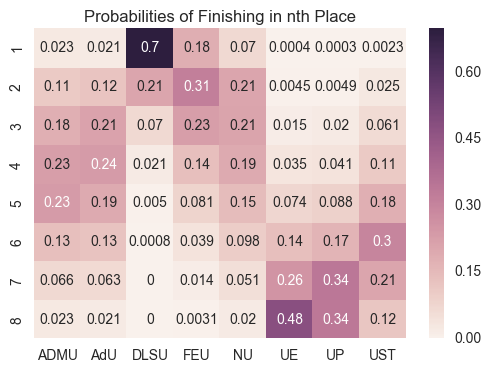

In [25]:
sns.heatmap(df_sim, annot = True)
plt.yticks(np.arange(0.5, len(df_sim.index), 1), df_sim.index[::-1])
plt.xticks(np.arange(0.5, len(df_sim.columns), 1), df_sim.columns)
plt.title("Probabilities of Finishing in nth Place")
plt.show()

Again, DLSU is very much favored to end up in first place. In reality, they indeed were the men's basketball champions for Season 79. 

Endnotes

In hindsight, the probabilities shown in the heat map didn't convey new insights. If you take the team with the highest probability on every rank, you'll get the same team rankings as the team rankings at the end of the 1st half of the season. DLSU was still 1st, UE was still 8th, etc.

Perhaps this was a result of overextending the intended use of this modelling approach in the original paper. The original paper's goal was to predict the total number of goals in a season of football matches. In my case, I took the extra step of simulating win/loss records from the simulated number of points in every game. I suspect that the simulations of the 2nd half of the season are simply coin tosses, so the predicted rankings are no different from the rankings at the end of the 1st half of the season.

In any case, it was a fun learning experience. Probabilistic programming is a great framework to have in the toolbox apart from blackbox machine lerning and traditional frequentist statistics. It takes more work to set up the priors and the dependencies among the random variables, but it results in a modelling approach that's both interpretable and flexible.